## Workspace setup. Libraries loading

In [5]:
import glob

import tensorflow as tf
import tensorflow_probability as tfp

import os, time, itertools
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from functools import partial
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32')

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

workerEnv = str(os.getenv("USER"))

## True efficiency function.

In [18]:
def efficiency(pt, eta):
    offset = 50+eta*eta*10
    offset = 50+20*np.sin(eta)
    x = pt-offset
    scale = 0.95 - tf.abs(eta)*0.1
    return 0.001+tf.math.sigmoid(x)*scale
    
def dataGenerator(batchSize):
    scale = [100, 2*2.1]
    offset = [0, -2.1]
    for i in itertools.count(1):
        #pt = tf.random.uniform(shape=shape, minval=0, maxval=100, dtype=tf.dtypes.float32)
        #eta = tf.random.uniform(shape=shape, minval=-2.1, maxval=2.1, dtype=tf.dtypes.float32)
        
        features = tf.random.uniform(shape=(batchSize,2))
        features = features*scale + offset
        
        flatRndm = tf.random.uniform(shape=(batchSize,))
        labels = flatRndm<efficiency(features[:,0], features[:,1])
        labels = tf.reshape(labels, (-1,1))
        yield features, labels

In [19]:
batchSize = 5 
dataGeneratorBatched = partial(dataGenerator, batchSize)
dataset = tf.data.Dataset.from_generator(dataGeneratorBatched,(tf.float32, tf.float32), 
                                                   output_shapes=(tf.TensorShape([batchSize,2]), tf.TensorShape([batchSize,1])))

for dataRow in dataset.take(1):
  print(dataRow) 

(<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[85.42272   ,  1.5866237 ],
       [20.349396  , -1.0008588 ],
       [31.185759  ,  0.2657168 ],
       [51.759956  ,  1.3691874 ],
       [57.938408  , -0.19186223]], dtype=float32)>, <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [0.],
       [0.],
       [1.]], dtype=float32)>)


## Plot the true efficiency function.

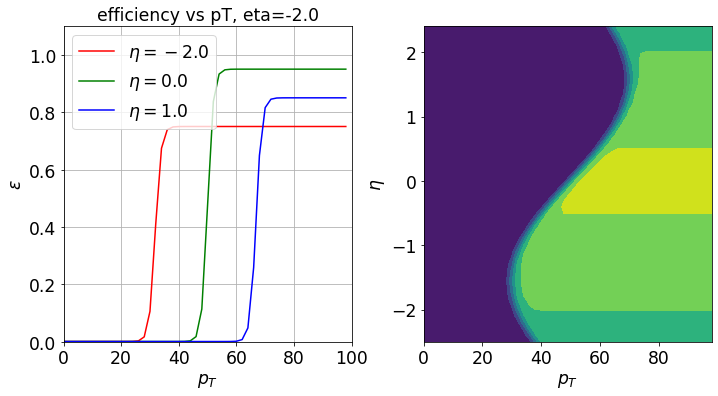

In [47]:
pt = tf.range(0,100,2.0)
eta = tf.range(-2.5, 2.5, 0.1)

pt_grid, eta_grid = tf.meshgrid(pt, eta)

fig, axes = plt.subplots(1, 2, figsize = (10, 6))  
axes[0].plot(pt, efficiency(pt, -2.0), "r", label = r'$\eta = -2.0$')
axes[0].plot(pt, efficiency(pt, 0.0), "g",label = r'$\eta = 0.0$')
axes[0].plot(pt, efficiency(pt, 1.0), "b",label = r'$\eta = 1.0$')

maxY = 1.1
maxX = 100
axes[0].set_ylabel(r'$\epsilon$');
axes[0].set_xlabel(r'$p_{T}$');
axes[0].grid()
axes[0].set_ylim([0,maxY])
axes[0].set_xlim([0,maxX])
axes[0].set_title("efficiency vs pT, eta=-2.0")
axes[0].legend(loc='upper left')

axes[1].contourf(pt_grid, eta_grid, efficiency(pt_grid, eta_grid))
axes[1].set_ylabel(r'$\eta$');
axes[1].set_xlabel(r'$p_{T}$');

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.35)

## Define the model

In [54]:
def getModel():
    
    nInputs = 2
    inputs = tf.keras.Input(shape=(nInputs,), name="features")
    x = tf.keras.backend.cast(inputs, tf.float32)
    activation = tf.keras.layers.Activation(tf.nn.relu)
    for iLayer in range(0,10):
        x = tf.keras.layers.Dense(128, activation=activation, name="layer_{}".format(iLayer))(x)
            
    outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid,
                                   bias_initializer='zeros',
                                   name = "efficiency")(x)              
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="NN_Efficiency")
    
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                decay_steps=1000,
                                                                decay_rate=0.95,
                                                                staircase=True)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
    return model

## Train the model

In [52]:
%%time
current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training start. Current Time =", current_time)

batchSize = 1024
batchDataGenerator = partial(dataGenerator, batchSize) 
train_dataset = tf.data.Dataset.from_generator(batchDataGenerator,(tf.float32, tf.float32), 
                                             output_shapes=(tf.TensorShape([batchSize,2]), tf.TensorShape([batchSize,1]))).take(1000)
train_dataset = train_dataset.cache()

validation_dataset = tf.data.Dataset.from_generator(batchDataGenerator,(tf.float32, tf.float32), 
                                             output_shapes=(tf.TensorShape([batchSize,2]), tf.TensorShape([batchSize,1]))).take(1)
model = getModel()
 
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

nEpochs = 50
history = model.fit(train_dataset, epochs=nEpochs,
                    use_multiprocessing=True,
                    verbose=0,
                    shuffle=False,
                    validation_data=validation_dataset,
                    #callbacks=[tensorboard_callback]
                   )

# Save the whole model
path = "training/model_{epoch:04d}"
model.save(path.format(epoch=nEpochs), save_format='tf')

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training end. Current Time =", current_time)

Training start. Current Time = Nov 03 2021 11:46:50


INFO:tensorflow:Assets written to: training/model_0050/assets


INFO:tensorflow:Assets written to: training/model_0050/assets


Training end. Current Time = Nov 03 2021 11:51:19
CPU times: user 4min 45s, sys: 3.57 s, total: 4min 49s
Wall time: 4min 28s


## Plot model vs. true function at eta=0.0

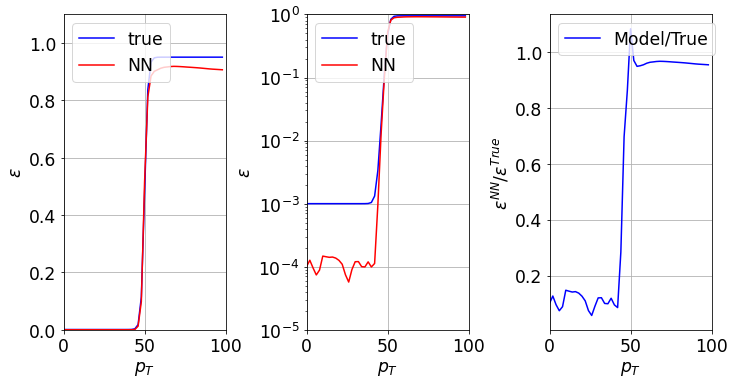

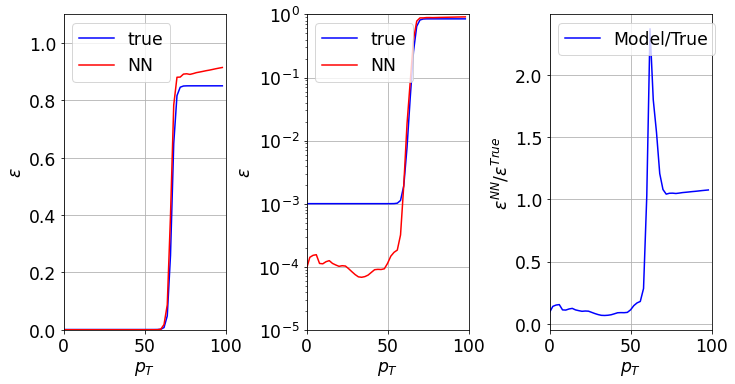

In [53]:
def plotEtaSlice(etaSlice):
    pt = tf.range(0,100,2.0)
    eta = tf.broadcast_to([etaSlice], pt.shape)

    features = tf.stack([pt, eta])
    features = tf.transpose(features)

    eff_model = model.predict(features, use_multiprocessing=True) 
    eff_model = tf.reshape(eff_model, (pt.shape))
    eff_true = efficiency(pt, eta)
    ratio = eff_model/eff_true

    fig, axes = plt.subplots(1, 3, figsize = (10, 6))  
    axes[0].plot(pt, eff_true, "b",label = "true")
    axes[0].plot(pt, eff_model, "r", label = "NN")

    axes[0].set_ylabel(r'$\epsilon$');
    axes[0].set_xlabel(r'$p_{T}$');
    axes[0].grid()

    maxY = 1.1
    maxX = 100
    axes[0].set_ylim([0,maxY])
    axes[0].set_xlim([0,maxX])
    axes[0].set_title("")
    axes[0].legend(loc='upper left')

    axes[1].plot(pt, eff_true, "b",label = "true")
    axes[1].plot(pt, eff_model, "r", label = "NN")

    axes[1].set_ylabel(r'$\epsilon$');
    axes[1].set_xlabel(r'$p_{T}$');
    axes[1].grid()
    axes[1].set_ylim([1E-5,1.0])
    axes[1].set_xlim([0,maxX])
    axes[1].set_yscale("log")
    axes[1].set_title("")
    axes[1].legend(loc='upper left')

    axes[2].plot(pt, ratio, "b",label = "Model/True")
    axes[2].set_ylabel(r'$\epsilon^{NN}/\epsilon^{True}$');
    axes[2].set_xlabel(r'$p_{T}$');
    axes[2].grid()
    #axes[2].set_ylim([0,5.0])
    axes[2].set_xlim([0,100])
    axes[2].set_title("")
    axes[2].legend(loc='upper left')

    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.5, hspace=0.5)
    
    
plotEtaSlice(etaSlice=0.0)
plotEtaSlice(etaSlice=1.0)

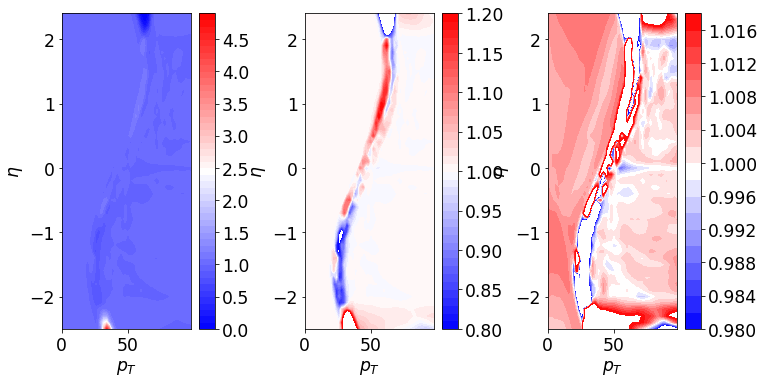

In [27]:
from matplotlib import ticker, cm

pt = tf.range(0,100,2.0)
eta = tf.range(-2.5, 2.5, 0.1)
pt_grid, eta_grid = tf.meshgrid(pt, eta)
pt_linear = tf.reshape(pt_grid, (-1))
eta_linear = tf.reshape(eta_grid, (-1))

features = tf.stack([pt_linear, eta_linear])
features = tf.transpose(features)

eff_model = model.predict(features, use_multiprocessing=True)
eff_model = tf.reshape(eff_model, (2500))
eff_true = efficiency(pt_linear, eta_linear)
ratio = eff_model/eff_true
ratio = tf.reshape(ratio, (50,50))

fig, axes = plt.subplots(1, 3, figsize = (10, 6))  
levels = tf.range(0.0, 5.0, 0.1)
cs = axes[0].contourf(pt_grid, eta_grid, ratio,levels=levels, cmap=cm.bwr)
cbar = plt.colorbar(cs, ax=axes[0])
axes[0].set_ylabel(r'$\eta$')
axes[0].set_xlabel(r'$p_{T}$')

levels = tf.range(0.8, 1.2, 0.01)
cs = axes[1].contourf(pt_grid, eta_grid, ratio,levels=levels, cmap=cm.bwr)
cbar = plt.colorbar(cs, ax=axes[1])
axes[1].set_ylabel(r'$\eta$')
axes[1].set_xlabel(r'$p_{T}$')

levels = tf.range(0.98, 1.02, 0.002)
cs = axes[2].contourf(pt_grid, eta_grid, ratio,levels=levels, cmap=cm.bwr)
cbar = plt.colorbar(cs, ax=axes[2])
axes[2].set_ylabel(r'$\eta$')
axes[2].set_xlabel(r'$p_{T}$')

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.5, hspace=0.35)